# **Hausing Market Analysis**
Project overview: 



## **Importing modules**

In the very first step of the process I'm importing the necessary modules for analysis and data aqusition.  

In [40]:
# webscrapper 
import webscrapper_functions as wf
from webscrapper_elements import SearchCriteria, MarketType, get_url_list
from csv import writer

# data analysis
import pandas as pd 
import numpy as np

# data vizualizations
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## **Data aquisition**

I have designed dedicated webscrapper to collect housing data directly from otodom.pl website. <br />
Programme has great amount of flexibility, allowing users to modify the search criteria <br />
and the size of downloaded datasets. Individual offer data is saved as record in CSV file. <br />
<br />
**Important Note**: Please do not run this cell unless you want to download the data. All necessary files are already provided.

In [80]:
# Choosing file name
file_name = "TEST.csv"

with open(file_name, 'w', encoding='utf8', newline='') as f:
    thewriter = writer(f)

    header = ["id", "title", "price", "city", "district", "street", 
                      "area", "rooms", "rent", "floor", "year", 
                      "balcony", "garage", "elevator", "furnishing", "extra_info",
                      "seller_type", "market", "ownership"]
    thewriter.writerow(header)
    
    # Defining search criteria
    search = SearchCriteria(
        market_type = MarketType.SECONDARY, 
        city = "gdansk", 
        limit = 72
    )
    
    # dataset size: (limit + 3) * num_of_pages
    # here: (72 + 3) * 10 = 750
    page_list = get_url_list(search, num_of_pages=10)
    
    for url in page_list:
        listings = wf.page_offer_list(url)
        for offer in listings:
            # main + location info
            main_info = wf.main_info(offer)
            location_info = wf.location_info(offer)

            # offer link + id 
            offer_url = wf.offer_url_generator(offer)
            offer_id = wf.offer_id_generator(offer_url)

            # accessing detailed offer data
            offer_soup = wf. offer_page_content(offer_url)
            detailed_info = wf.detailed_info(offer_soup)

            # all info
            all_info = wf.gather_offer_data(main_info, location_info, detailed_info, offer_id)

            # add data to csv
            thewriter.writerow(all_info)

## **Importing data**

In this step I'm converting CSV files into pandas dataframes. <br /> 
<br />
Both datasets store filtered data from Gdańsk. <br />
`primary` includes offers from primary market and `secondary` includes offers from secondary market  <br />
<br />
**Important Note**: Significant portion of the offers in `primary` didn't contain the information about price. <br />
Since this is one of the most important parameters, I have decided to exclude these records. <br />
<br />
`alldata` combines `dprimary` and `dsecondary`

In [71]:
primary = pd.read_csv("hdata_primary.csv")
primary = primary[primary.price != "Zapytaj o cenę"]

secondary = pd.read_csv("hdata_secondarymarket.csv")

alldata = pd.concat([primary, secondary]).reset_index()

# Checking the number of records in each dataset
print(f"primary: {len(primary)}",
      f"secondary: {len(secondary)}",
      f"alldata: {len(alldata)}",
      sep = "\n")

primary: 444
secondary: 750
alldata: 1194


## **Exploratory data analysis**

The main goal of EDA phase is to learn the structre of the data. Furthermore, thhis is also a great <br /> 
opportunity to discover any inconsistencies or missing valus across the dataset. <br /> 
<br /> 

At the beginning, I will investigate the first three rows of `alldata` dataset.

In [85]:
alldata.head(3)

,index,id,title,price,city,district,street,area,rooms,rent,floor,year,balcony,garage,elevator,furnishing,extra_info,seller_type,market,ownership
0,0,ID4g5qm,"Apartament 4 pokojowy, blisko morza",767 018 zł,Gdańsk,Letnica,NaN,"75,22 m²",4.0,zapytaj,2/6,NaN,zapytaj,zapytaj,nie,NaN,NaN,biuro nieruchomości,pierwotny,zapytaj
1,1,ID4gh74,Gdańsk Osowa Seleny nowe wygodne mieszkanie,749 000 zł,Gdańsk,Osowa,ul. Seleny,122 m²,6.0,zapytaj,1/1,NaN,taras,garaż/miejsce parkingowe,nie,NaN,"oddzielna kuchnia, dwupoziomowe",prywatny,pierwotny,zapytaj
2,3,ID4e9AW,5-pokojowe mieszkanie 91m2 + balkon Bezpośrednio,929 220 zł,Gdańsk,Ujeścisko-Łostowice,NaN,"91,1 m²",5.0,zapytaj,2/4,NaN,balkon,garaż/miejsce parkingowe,NaN,NaN,NaN,NaN,NaN,pełna własność


#### **Checking column data types** 

As we can see above, our data is likely to have a few limitations. We can already notice that the price is probably <br />
in a string format (currency is the part of the value). Moreover there are some missing in many columns. <br />
<br />
To ensure the data is consistent I'm going to check the data dypes and unique values <br />
for each relevant column (I will exclude columns such as `title` or `id` since they are not going to be a part of analysis)

In [4]:
alldata.drop(labels = ["index", "id", "title"], axis = 1, inplace =  True)
alldata.dtypes  

price           object
city            object
district        object
street          object
area            object
rooms           object
rent            object
floor           object
year           float64
balcony         object
garage          object
elevator        object
furnishing      object
extra_info      object
seller_type     object
market          object
ownership       object
dtype: object

#### **Exploring unique values**

Colums that are supposed to have numerical values  (`price`, `area`, `rooms`, `year`) are not formated as floats or strings. <br />
<br />
In the next code cell I'm going to check uniqe values for each column. Iterating the loop is an efficent method to <br />
quickly see all the values and catch errors 

In [5]:
unique_values_dict = {}

"""Building dictionary to store column names and coresponding unique values."""
for column in alldata.columns:
    unique_values_dict[column] = alldata[column].unique()
    
"""Printing the results."""
for key, item in unique_values_dict.items():
    print(key, item)
    print("\n")

price ['767\xa0018\xa0zł' '749\xa0000\xa0zł' '929\xa0220\xa0zł'
 '669\xa0000\xa0zł' '825\xa0428\xa0zł' '750\xa0088\xa0zł'
 '450\xa0000\xa0zł' '923\xa0247\xa0zł' '1\xa0028\xa0761\xa0zł'
 '649\xa0000\xa0zł' '822\xa0769\xa0zł' '399\xa0122\xa0zł'
 '509\xa0037\xa0zł' '398\xa0197\xa0zł' '503\xa0671\xa0zł'
 '1\xa0290\xa0000\xa0zł' '564\xa0002\xa0zł' '483\xa0075\xa0zł'
 '542\xa0024\xa0zł' '342\xa0500\xa0zł' '477\xa0486\xa0zł'
 '903\xa0000\xa0zł' '790\xa0763\xa0zł' '335\xa0000\xa0zł'
 '348\xa0000\xa0zł' '724\xa0869\xa0zł' '497\xa0670\xa0zł'
 '1\xa0208\xa0000\xa0zł' '580\xa0000\xa0zł' '1\xa0590\xa0000\xa0zł'
 '360\xa0000\xa0zł' '486\xa0500\xa0zł' '526\xa0000\xa0zł'
 '618\xa0576\xa0zł' '315\xa0651\xa0zł' '285\xa0000\xa0zł'
 '363\xa0286,15\xa0zł' '535\xa0000\xa0zł' '820\xa0875\xa0zł'
 '513\xa0000\xa0zł' '756\xa0242\xa0zł' '349\xa0000\xa0zł'
 '564\xa0544\xa0zł' '430\xa0000\xa0zł' '560\xa0000\xa0zł'
 '316\xa0500\xa0zł' '696\xa0000\xa0zł' '508\xa0322\xa0zł'
 '861\xa0702,41\xa0zł' '482\xa0630\xa0zł' '

#### **Conclusions** 

1. Numeric values should be formated as *floats* or *ints* not objects
2. Missing values (nan) are present in dataset. In case of some columns they will require further inspection.
3. Strange values such as *"zapytaj"* should be replaced in further steps of analysis. 
4. `Floor` column also has information about total floor number. If needed there is the possibility to split the column.

    <br />

## **Cleaning the data**
Part I of the analysis requires us to modify and clean the following columns: <br />

- `price` - convert to float64 (chage current strange format and remove currency "zł")
- `area` - convert to float64 (remove "m²")
- `rent` - convert to float64 (remove currency "zł"), missing values are going to be replaced with mean value
- `rooms` -convert to float64
- `city` - exclude any record that is not from Gdańsk (although data was filtered by city at data accuisition stage,  <br />
we can notice some strange values. Most likely these are the result of people inpuuting offer data in inappropriate fields)




#### **Cleaning functions**

Here, I design cleaning functions so in the next step I can apply them on dedicated columns. 

In [27]:
"""Cleaning: PRICE"""
def extract_price(value):
    value = value.replace(u"\xa0", u"") \
                 .replace(",", ".")               
    return float(value[:-2])

"""Cleeaning: AREA"""
def extract_area(value):
    if isinstance(value, str):
        value = value.replace(",", ".") \
                     .replace("m²", "") \
                     .strip() 
    return float(value)

"""Cleaning: RENT"""
def extract_rent(value):
    # I found one missing value formated as np.nan
    # Therefore I change it to "zapytaj" to match other missing values 
    if isinstance(value, float):
        value = "zapytaj"
    if value != "zapytaj":
        value = value.replace(" ", "") \
                     .replace(",", ".")
        value = float(value[:-2])
    return value

def replace_rent(value):
    # calculation of mean
    mean = alldata.rent[alldata.rent != "zapytaj"].mean()
    if value == "zapytaj":
        value = mean
    return value

"""Cleaning: ROOMS"""
def extract_rooms(value):
    if isinstance(value, str):
        try: 
            value = float(value.strip())
        except ValueError: 
            value = 10.0 
    return value

"""Cleaning: CITY"""
alldata = alldata[alldata.city == "Gdańsk"]

#### **Updating dataframe**

In [72]:
# PRICE
alldata.price = alldata.price.apply(extract_price)

#AREA
alldata.area = alldata.area.apply(extract_area)

#RENT
alldata.rent = alldata.rent.apply(extract_rent)
alldata.rent = alldata.rent.apply(replace_rent)

#ROOMS
alldata.rooms = alldata.rooms.apply(extract_rooms)

#### **Cleaning tests**

Now, all columns selected for modification are saved in appropriate format. <br />
Thanks to this change, it is possible to carry matematical opperations on these columns.

In [8]:
dtype_test = alldata[["price", "area", "rent", "rooms"]]
print(dtype_test.dtypes)
print(alldata.city.unique())

price    float64
area     float64
rent     float64
rooms    float64
dtype: object
['Gdańsk']


## **Analysis**

The ultimate goal of the analysis is to investigate how different factors affect the prices of properties. <br />

#### **Market overview**

At the begining, its important to check the general metrics. We can see below that there is quite substential <br />
difference between average and median price values. Mean value is larger then the median, as a result we can already suspect <br />
that the price distribution is right skewd.

In [9]:
summary = f"""General statistics:
Total number of properties: {len(alldata)}  
Avearge price: {alldata.price.mean():.2f}  
Median price {alldata.price.median()} 
Avearge rent: {alldata.rent.mean():.2f}  
"""
print(summary)

General statistics:
Total number of properties: 1188  
Avearge price: 716326.62  
Median price 598000.0 
Avearge rent: 498.89  



#### **Price distribution**

To illustrate this further let's look at the histogram. We can deffinitely confirm our initial assumpition <br />
about the distribution. The majority of offers listed fall between 300,000 and 1 millon price range. <br />
The assymetry is an obvios implication of very expensive proprties listed that are not that frequent.

**Important note**: In order to increae the readability of the chart, I only selected properties <br />
with price below 3,500,000 pln.

 

<AxesSubplot:xlabel='price', ylabel='Count'>

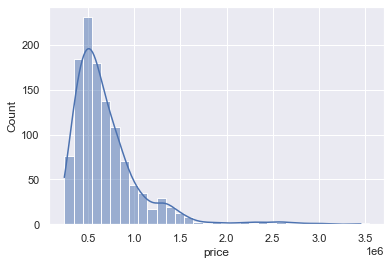

In [10]:
sns.set_theme(style="darkgrid")
sns.histplot(data=alldata[alldata.price < 3500000], 
             x="price", 
             binwidth=100000, 
             kde=True,
             )


Second vizualisation displays price distributions depending on the number of rooms. I have deselected properties <br />
with 6 or more rooms since there is to litte data about. Thereby, these offers are insignificant for the analysis. <br />
<br />
As expected, when the numer of rooms increases, so does the mean value and distribution "moves to the right"

C:\Users\budcr\AppData\Local\Temp/ipykernel_17260/373347284.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  facet_grid_data = alldata[alldata.rooms<6][alldata.price < 2500000]


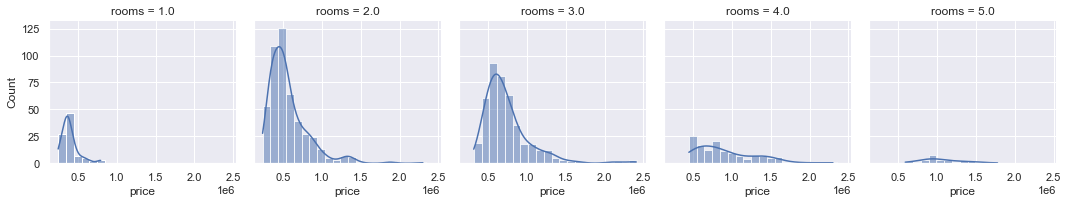

In [11]:
facet_grid_data = alldata[alldata.rooms<6][alldata.price < 2500000]

grid = sns.FacetGrid(facet_grid_data, col="rooms")
grid.map(sns.histplot, "price", binwidth=100000, kde=True)

#### **What are the most and least expensive districts?** 

In this part of the analysis, my goal is to discover how districts affect the price. <br /> 
<br />
I've created a function that calculates summary statistics for grupped data. Here, I group data by the distirict and <br />
measure the prices. I'm displaying only districts with 15 or more listings. This prevents showing areas with little data or <br />
that were simply wrongly formated.

In [12]:
def summarise_stats(groupby: str, values_column: str, min_count=5):
    data_by_column = alldata.groupby(groupby)[values_column].agg([np.mean, np.median, min, max, len])
    data_by_column = data_by_column[data_by_column.len > min_count].round(2)
    return  data_by_column

stats_by_district = summarise_stats(groupby = "district", values_column = "price", min_count = 15)
stats_by_district = stats_by_district.sort_values(by = "mean", ascending = False)
stats_by_district

,mean,median,min,max,len
district,,,,,
Oliwa,1118733.48,960000.0,399000.0,2700000.0,48
Śródmieście,1025993.14,849000.0,285000.0,10900000.0,127
Brzeźno,931208.61,689000.0,349000.0,2850000.0,28
Wrzeszcz,892643.22,770000.0,399000.0,2550000.0,107
Zaspa,807772.86,740000.0,365000.0,1570000.0,35
Piecki-Migowo,750551.72,699000.0,447702.0,1475000.0,53
Przymorze,737296.05,669000.0,319000.0,3695000.0,80
Letnica,702358.23,676000.0,434000.0,1327000.0,58
pomorskie,680359.95,543974.0,241258.0,1444705.0,22


Bar chart illustrates the arranged oreder of most expensive districts in Gdańsk. Results are quite clear. <br />
On average the most expensive districts are 'Oliwa' and 'Śródmieście' with the cheapest being 'Orunia Górna-Gdańsk Południe' <br />
<br />
We can also notice, judging by the number of offers posted (`len` column) that districts 'Ujeścisko-Łostowice' and 'Jasień' <br />
are either quickly developing or people there are willing to change their place of living (they have the largest amounts <br />
of new offers: 185 and 158 respectively)

In [13]:
fig = px.bar(stats_by_district.reset_index(), x='district', y='mean', hover_data=['mean', 'median', "min", "max"])
fig.show()

#### **How number of rooms impacts the price?** 

In [14]:
stats_by_num_rooms = summarise_stats(groupby = "rooms", values_column = "price", min_count = 15)
stats_by_num_rooms.sort_values(by = "mean")

,mean,median,min,max,len
rooms,,,,,
1.0,399227.42,369000.0,249200.0,794970.0,91
2.0,575595.26,499000.0,241258.0,2758000.0,481
3.0,773084.39,679000.0,320000.0,3456950.0,437
4.0,1025763.04,826714.0,449500.0,4400000.0,144
5.0,1268253.40,1028761.0,595000.0,4300000.0,31


C:\Users\budcr\AppData\Local\Temp/ipykernel_17260/2704619711.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



<AxesSubplot:xlabel='rooms', ylabel='price'>

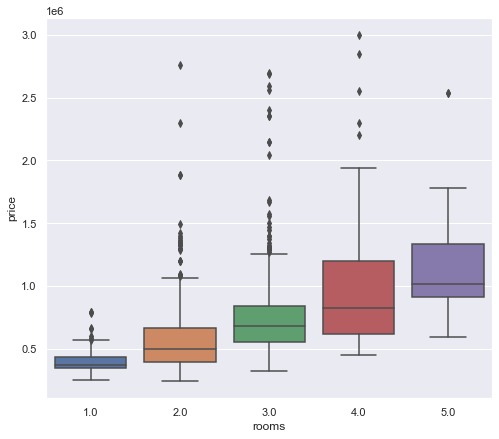

In [15]:
data_boxplot = alldata[alldata.rooms < 6][alldata.price < 3000000]

plt.figure(figsize=(8,7))
fig = sns.boxplot(data=data_boxplot, x="rooms", y="price")
fig

**Important note**: I have intenionally sliced the dataset to better ilustrate the distributions. <br />
I also included only properties with 5 rooms at maximum and with price lower then 3 million PLN. <br />
 Decreasing the amount of outliers raises the readability of the boxplots.

## **Analysis - Qualitative variables**

What is necessary?
What parameters to include

#### **Cleaning qualitative variables columns**

Turning columns into boolen format:
- `seller_type` - is private (0/1)
- `market` - 0 - secondary, 1 - primary market
- `elevator`- has elevator (0/1)
- `balcony` - has balcony/garden (0/1)
- `garage` - has garage (0/1)
- `extra_info` - splitting into two new columns: `cellar` and `utility_room`. 

In [43]:
def format_seller_type(value):
    if value == "prywatny": value = 1
    else: value = 0
    return value
    
def format_market(value): 
    if value == "wtorny": value = 0
    else: value = 1
    return value

def format_elevator(value):
    if value == "tak": value = 1
    else: value = 0
    return value
    
def format_balcony(value): 
    if isinstance(value, str):
        if "balkon" in value or "taras" in value: 
            value = 1
        else: value = 0
    else: value = 0
    return value

def format_garage(value): 
    if isinstance(value, str):
        if "garaż" in value: value = 1
        else: value = 0
    else: value = 0
    return value

def format_cellar(value): 
    if isinstance(value, str):
        if "piwnica" in value: value = 1
        else: value = 0
    else: value = 0
    return value

def format_utiliity_room(value): 
    if isinstance(value, str):
        if "pom. użytkowe" in value: 
            value = 1   
        else: value = 0
    else: value = 0
    return value

In [73]:
alldata.seller_type = alldata.seller_type.apply(format_seller_type)
alldata.market = alldata.market.apply(format_market)
alldata.elevator = alldata.elevator.apply(format_elevator)
alldata.balcony = alldata.balcony.apply(format_balcony)
alldata.garage = alldata.garage.apply(format_garage)


alldata.loc[:, "cellar"] = alldata["extra_info"].apply(format_cellar)
alldata.loc[:, "utility_room"] = alldata["extra_info"].apply(format_utiliity_room)

#### **Does garage increase the average cost of the property?**

#### **What are the differances between offers from secondary compared to primary market?**

## **Analysis - Regression model**

What is necessary?
What parameters to include

In [76]:
x = alldata[['area', 'rooms', 'balcony', 
             'garage', 'elevator', 'cellar', 'utility_room', 
             'balcony', 'market', 'seller_type']]

y = alldata[['price']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2)

x.to_csv("ML.csv")

In [77]:
mlr = LinearRegression()

model = mlr.fit(x_train, y_train)

y_predict = mlr.predict(x_test)

# Input code here:
print(mlr.coef_)

[[ 12919.70400858 -48695.42064962 -11430.0770966   19306.4526537
  143531.75087865 -63013.98476898  48396.48433173 -11430.0770966
       0.          81660.37567818]]
